<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Basic_resnet_explorationTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install fastai2 from github

In [1]:
!pip install -Uqq fastcore --upgrade
!pip install -Uqq fastai --upgrade 
!pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions

     |████████████████████████████████| 358kB 3.3MB/s 


In [2]:
VERSION = "20200707"  #"20200515" @param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  32169      0 --:--:-- --:--:-- --:--:-- 32169


In [3]:
#!TORCH_SHOW_CPP_STACKTRACES=1 python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
!python pytorch-xla-env-setup.py  --version $VERSION --apt-packages libomp5 libopenblas-dev

Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200707 ...
     |████████████████████████████████| 61kB 2.5MB/s 
Uninstalling torch-1.6.0+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.5 MiB/107.5 MiB]                                                
Operation completed over 1 objects/107.5 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200707-cp36-cp36m-linux_x86_64.whl...
\ [1 files][123.8 MiB/123.8 MiB]                                                
Operation completed over 1 objects/123.8 MiB.                     

In [4]:
!pip freeze | grep torch 
!pip freeze | grep fastcore
!pip freeze | grep fastai

torch==1.7.0a0+12b5bdc
torch-xla==1.6+5430aca
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.0a0+86b6c3e
fastcore==1.0.0
fastai==2.0.0
fastai-xla-extensions==0.0.1


In [1]:
import fastai_xla_extensions.core

In [2]:
from fastai.vision.all import *

In [3]:
from fastai_xla_extensions.core import default_device, to_device

In [4]:
default_device

<function fastai_xla_extensions.core.default_device>

In [5]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path; path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

# Lenet with convs and F.max_pool2d

In [ ]:
# class MyLenet(nn.Module):
#     def __init__(self):
#         super(MyLenet, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 3)
#         self.conv2 = nn.Conv2d(6,16,3)
#         self.hiden4 = nn.Linear(400, 2) # 2 outputs instead of 10
#     def forward(self, x):
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = self.hiden4(x)
#         return x
    
#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features


# Lenet with layers

In [ ]:
# class Lenet2(nn.Module):
#     def __init__(self):
#         super(Lenet2, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 3)
#         self.conv2 = nn.Conv2d(6, 16, 3)
#         self.fc1 = nn.Linear(400, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 2) # Only 2 outputs instead of 10
#     def forward(self, x):
#         # Max pooling over a (2, 2) window
#         x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
#         # If the size is a square you can only specify a single number
#         x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = x.view(-1, self.num_flat_features(x))
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def num_flat_features(self, x):
#         size = x.size()[1:]  # all dimensions except the batch dimension
#         num_features = 1
#         for s in size:
#             num_features *= s
#         return num_features




# Current TPU implementation callbacks

# Load in TPU

In [8]:
dblock = DataBlock(
    splitter = GrandparentSplitter(),
    item_tfms = Resize(28),
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
    batch_tfms = []
)


In [9]:
dblock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 12396,2038
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/7/22955.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_sample/train/7/22955.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (28, 28), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

# Use TPU device

# Aquire a TPU device

In [10]:
dls_tpu = dblock.dataloaders(path, device=default_device())
dls_tpu.vocab

(#2) ['3','7']

In [11]:
xb, yb = dls_tpu.one_batch()

In [12]:
(type(xb), xb.shape, xb.dtype)

(fastai.torch_core.TensorImage, torch.Size([64, 3, 28, 28]), torch.float32)

In [13]:
(type(yb), yb.shape, yb.dtype)

(fastai.torch_core.TensorCategory, torch.Size([64]), torch.int64)

In [14]:
dls_tpu.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

## First training on TPU

In [ ]:
# from fastai.callback.all import *
# from fastai.test_utils import *
# lenet_tpu = Lenet2()
# tpu_learner = Learner(dls_tpu,
#                       lenet_tpu,
#                       metrics=accuracy, 
#                       loss_func=F.cross_entropy,
#                       cbs=[])

In [15]:
tpu_learner = cnn_learner(dls_tpu, resnet18, pretrained=False, metrics=accuracy)

In [36]:
# tpu_learner.unfreeze()

In [16]:
tpu_learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

In [17]:
tpu_learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, XLAOptCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch 

In [18]:
dls_tpu.device

device(type='xla', index=1)

# Call fit

Will fail in `self.loss.backward(); `?

In [19]:
tpu_learner.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.053117,0.009278,0.996565,00:40


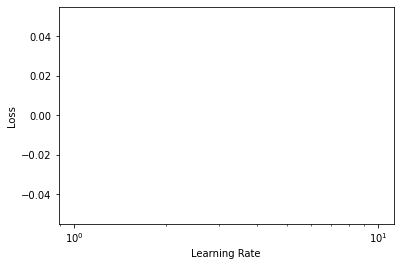

In [20]:
tpu_learner.lr_find()

In [21]:
%%time
tpu_learner.fit_one_cycle(1)
tpu_learner.validate()

epoch,train_loss,valid_loss,accuracy,time
0,0.013210,0.009502,0.997056,00:28


CPU times: user 12 s, sys: 1.21 s, total: 13.2 s
Wall time: 31.6 s


In [22]:
class DeviceCheckCallback(Callback):
    
    def after_pred(self):
        print(f'xb device: {first(self.learn.xb).device}')
        print(f'model device: {one_param(self.learn.model).device}')


In [23]:
tpu_learner.fit_one_cycle(1, cbs=[DeviceCheckCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.019918,0.005847,0.998037,00:26


xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
xb device: xla:1
model device: xla:1
x